# Electricity Dataset

https://paperswithcode.com/dataset/electricity

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

from darts.metrics import mape, mse, rmse, mae
from darts.models.filtering.moving_average_filter import MovingAverageFilter

import pickle

import os

In [3]:
def print_metrics(name, series, forecast):
  print(name + ' metrics:')
  print('MAPE = {:.2f}%'.format(mape(series, forecast)))
  print('RMSE = {:.2f}'.format(rmse(series, forecast)))
  print('MSE = {:.2f}'.format(mse(series, forecast)))
  print('MAE = {:.2f}'.format(mae(series, forecast)))
  print('')


In [4]:
def plot_forecast(series, forecast, title):
    plt.figure(figsize=(25,5))
    series.plot(label="actual")
    forecast.plot(label="forecast")
    plt.title(title)
    plt.legend()
    plt.show()


In [5]:
df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})

/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/ipykernel_54772/896581101.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/ipykernel_54772/896581101.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})


In [6]:
df.head()

,ds,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce').astype(np.float32)
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce').astype(np.float32)
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce').astype(np.float32)
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce').astype(np.float32)
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce').astype(np.float32)
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce').astype(np.float32)
df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'], errors='coerce').astype(np.float32)

df.head(100)

,ds,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.839996,18.400000,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630005,23.000000,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.289993,23.000000,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740005,23.000000,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.679993,15.800000,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
95,2006-12-16 18:59:00,4.224,0.090,231.960007,18.200001,0.0,1.0,16.0
96,2006-12-16 19:00:00,4.070,0.088,231.990005,17.400000,0.0,1.0,17.0
97,2006-12-16 19:01:00,3.612,0.090,232.360001,15.600000,0.0,2.0,16.0
98,2006-12-16 19:02:00,3.458,0.090,232.710007,14.800000,0.0,1.0,17.0


In [8]:
# count NA values
df.isna().sum() / len(df)

ds                       0.000000
Global_active_power      0.012518
Global_reactive_power    0.012518
Voltage                  0.012518
Global_intensity         0.012518
Sub_metering_1           0.012518
Sub_metering_2           0.012518
Sub_metering_3           0.012518
dtype: float64

In [9]:
# fill NA values with the previous value
df = df.ffill()

## Load time series data

In [10]:
TRAIN_DAYS = 60
PREDICTION_HOURS = 24

In [11]:
def get_series_from_dataframe(dataframe, column_name):
    s = TimeSeries.from_dataframe(dataframe, time_col='ds', value_cols=column_name, freq=None, fill_missing_dates=True)
    s = s.slice_n_points_before(s.end_time(), TRAIN_DAYS*24*60)
    s = s.resample('10min', method='pad')

    ma_filter = MovingAverageFilter(12)
    s = ma_filter.filter(s)

    return s

series = get_series_from_dataframe(df, 'Global_active_power')


In [12]:
print(len(series))

8641


<Axes: xlabel='ds'>

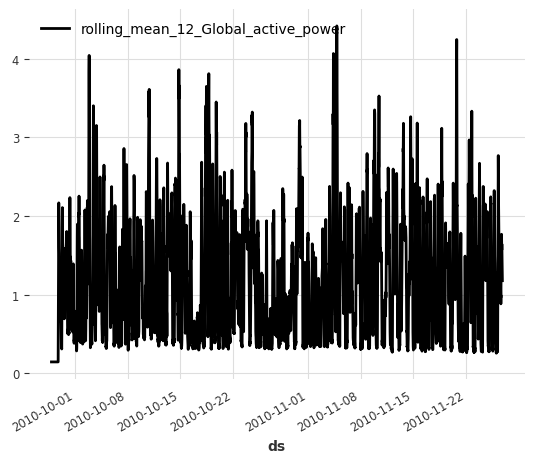

In [13]:
series.plot()

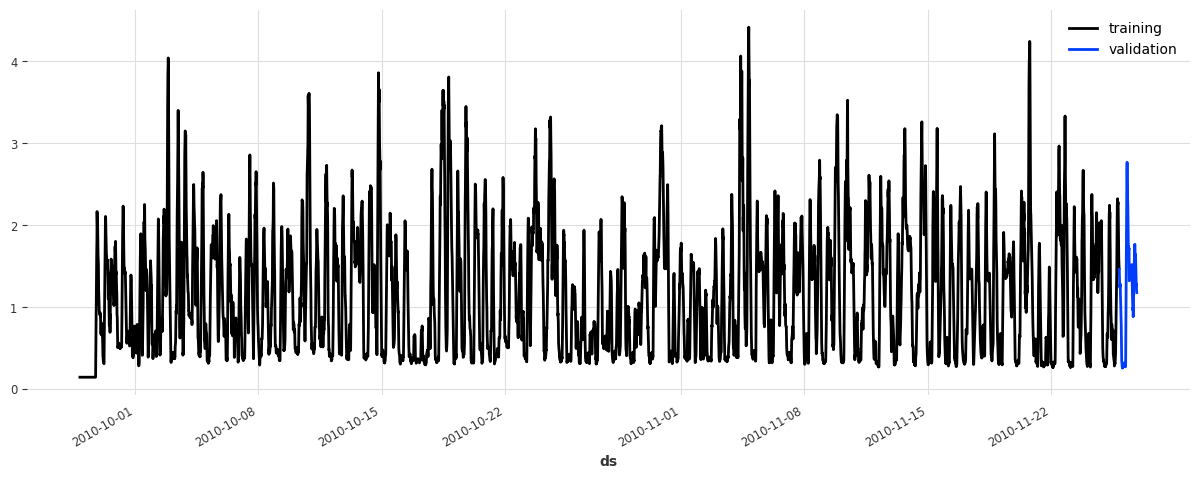

In [14]:
train, val = series.split_after((TRAIN_DAYS - 1) / TRAIN_DAYS)
plt.figure(figsize=(15, 5))
train.plot(label="training")
val.plot(label="validation")

to_predict = len(val)
series_after_train = series.slice_intersect(val)

## Baseline Model

<Axes: xlabel='ds'>

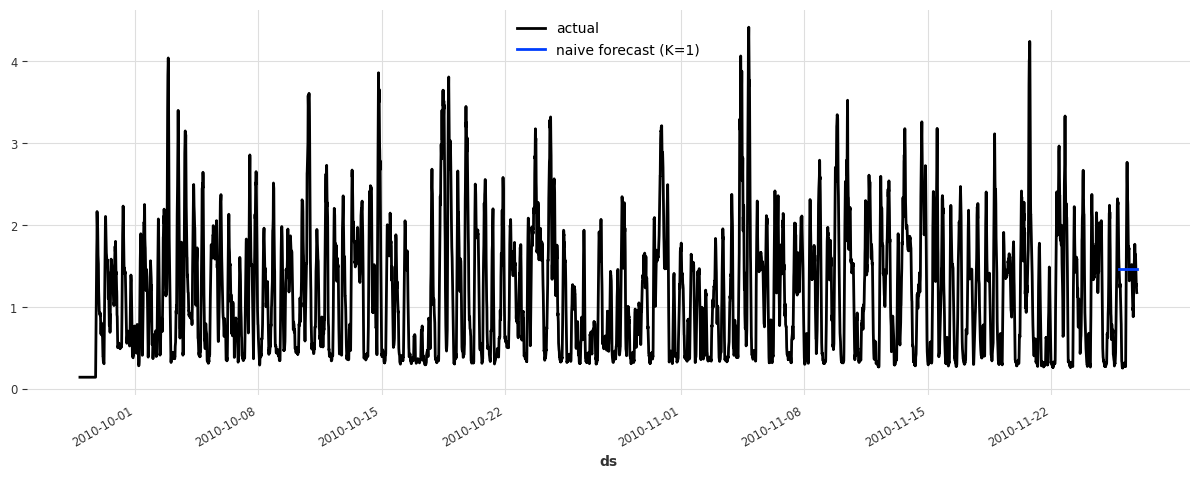

In [15]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
plt.figure(figsize=(15, 5))
naive_model.fit(train)
naive_forecast = naive_model.predict(to_predict)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

---

# XGBoost model

In [16]:
from darts.models.forecasting.xgboost import XGBModel

try:
    with open('xgb_model.pkl', 'rb') as f:
        xgb_model = pickle.load(f)
except FileNotFoundError:
    xgb_model = None

if xgb_model is not None:
    print('xgb_model loaded')
else:
    xgb_model = XGBModel(
        lags=24 * 7 * 6,
        output_chunk_length=100,
    )
    xgb_model.fit(train, verbose=True)

    pickle.dump(xgb_model, open('xgb_model.pkl', 'wb'))

xgb_forecast = xgb_model.predict(to_predict)


xgb_model loaded


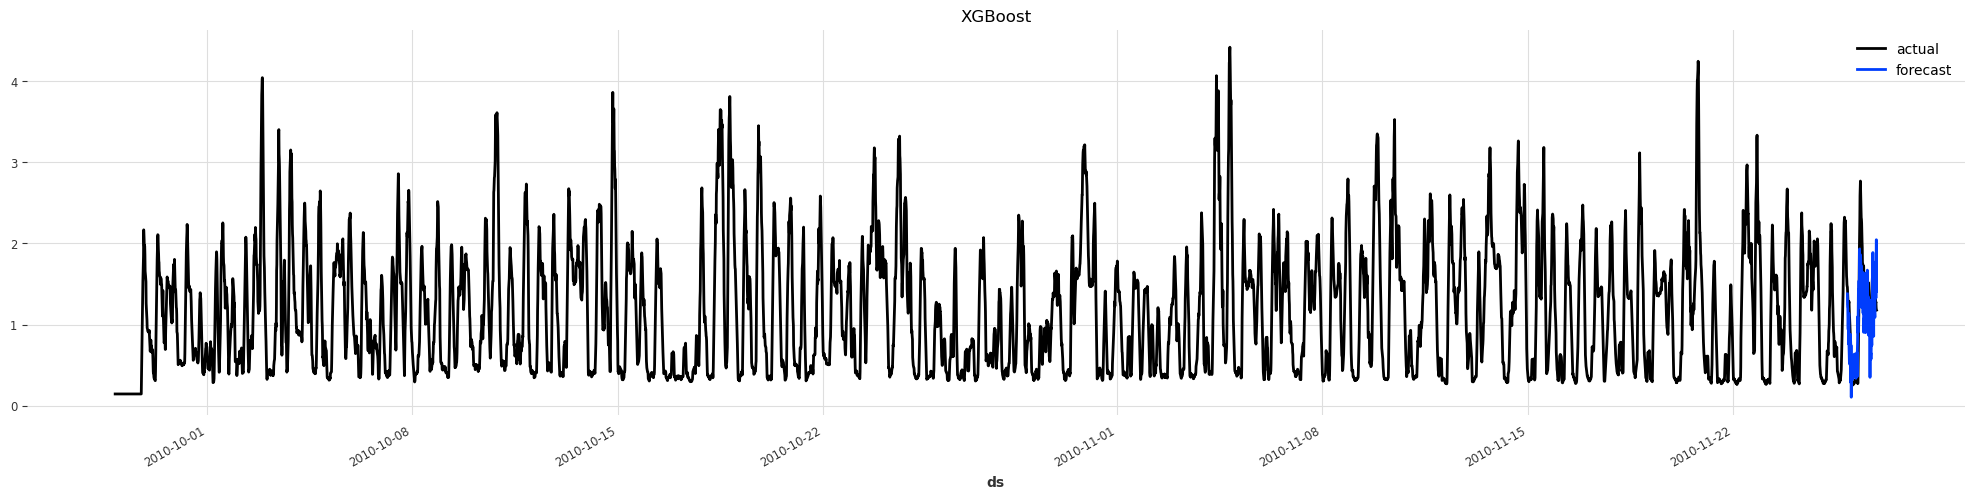

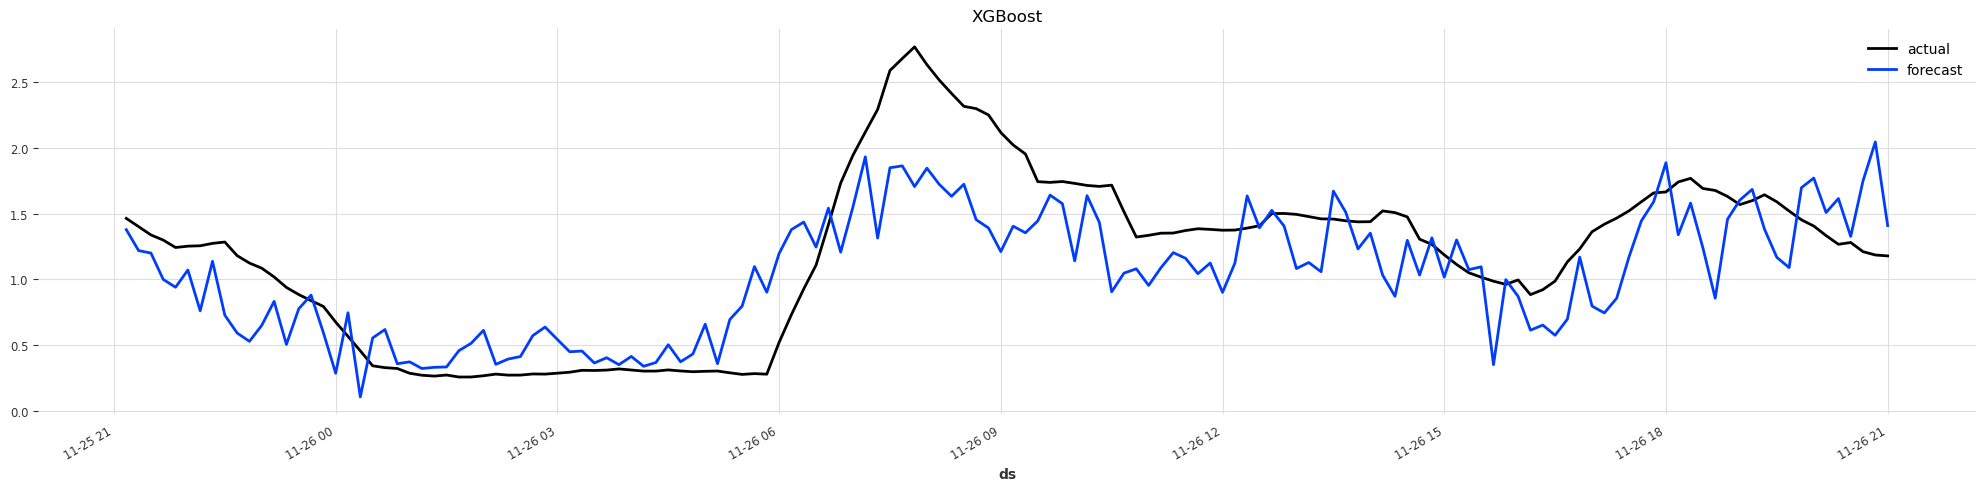

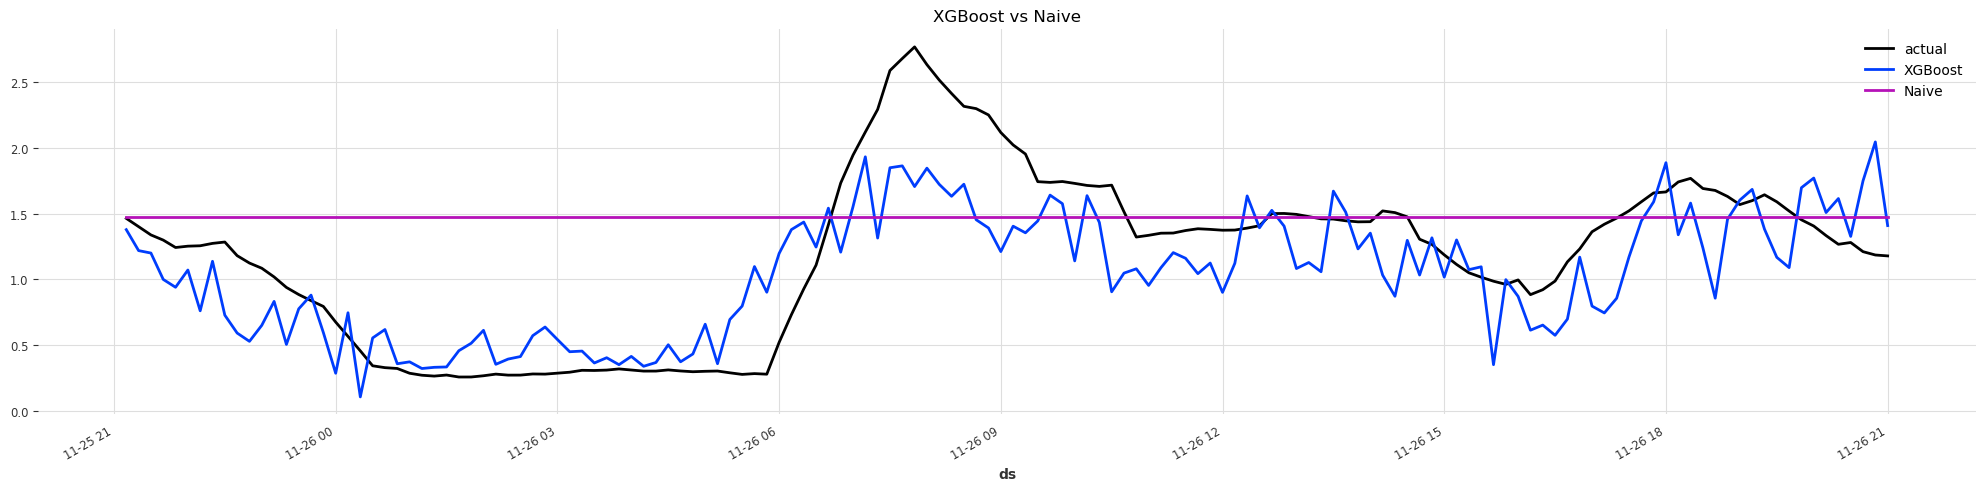

In [17]:
plot_forecast(series, xgb_forecast, "XGBoost")
plot_forecast(series_after_train, xgb_forecast, "XGBoost")

# plot xgboost forecast with naive on the same plot not using plot_forecast
plt.figure(figsize=(25,5))
series_after_train.plot(label="actual")
xgb_forecast.plot(label="XGBoost")
naive_forecast.plot(label="Naive")
plt.title("XGBoost vs Naive")
plt.legend()
plt.show()


In [18]:
print_metrics('XGBoost', val, xgb_forecast)
print_metrics('Naive', val, naive_forecast)

XGBoost metrics:
MAPE = 36.21%
RMSE = 0.41
MSE = 0.17
MAE = 0.32

Naive metrics:
MAPE = 113.92%
RMSE = 0.69
MSE = 0.48
MAE = 0.52



----

# Time GPT

In [19]:
from nixtlats import TimeGPT  # Importing the TimeGPT class from nixtlats library.


In [20]:
timegpt = TimeGPT(token='zIfJOm56yShsVWB9HCF9eoVAukNN0shnJbVshhYhyNKkKHg6AtMLHIyZW7jmkDO9fF4HBUUNeAmXYFUMcECxbtwSEHe62UMmaZcWBq4uVyalSUzTCueLrDAPNnY7vveFVRPoHKES7heOYYiA6oKyQBqCF5rQ2ejmJrVUtFJAjSbVYRYdh8t5yrysyzXeYw1yqA7Iz2EkD1n3Ac57G8ezuLyC7k9DY0Na9CwVYwxQzzbiBk383ePikmWwvtcCbmkQ')

In [21]:
try:
    if timegpt.validate_token():
        print("Token validation successful!")  # Token is valid.
    else:
        print("Token validation failed!")  # Token is invalid.
except Exception as e:
    print("Token validation failed!")

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


Token validation successful!


In [22]:
# to pandas dataframe
time_gpt_train_df = train.pd_dataframe().dropna()

# make index as separate column named timestamp
time_gpt_train_df['timestamp'] = time_gpt_train_df.index

# rename column Global_active_power to value
time_gpt_train_df = time_gpt_train_df.rename(columns={'rolling_mean_12_Global_active_power': 'value'})

# drop index
time_gpt_train_df = time_gpt_train_df.reset_index(drop=True)

In [23]:
time_gpt_forecasts = []

try:
  for i in range(10, len(series_after_train), 20):
    # check if forecast already exists
    if os.path.exists('data/timegpt_forecast_' + str(i) + '.csv'):
      print('forecast already exists for', i)
      continue

    print('fetching predictions for', i)

    if (i < 40):
      time_gpt_forecast = timegpt.forecast(df=time_gpt_train_df, h=i, time_col='timestamp', target_col='value', id_col='timestamp', fewshot_loss='mse', fewshot_steps=10)
    else:
      time_gpt_forecast = timegpt.forecast(df=time_gpt_train_df, h=i, time_col='timestamp', target_col='value', id_col='timestamp', fewshot_loss='mse', model='long-horizon', fewshot_steps=10)

    time_gpt_forecasts.append(time_gpt_forecast)

    time_gpt_forecast.to_csv('data/timegpt_forecast_' + str(i) + '.csv', index=False)
    print('saved forecast for', i)
except Exception as e:
  print('api call failed', e)


forecast already exists for 10
forecast already exists for 30
forecast already exists for 50
forecast already exists for 70
forecast already exists for 90
forecast already exists for 110
forecast already exists for 130


## TimeGPT results

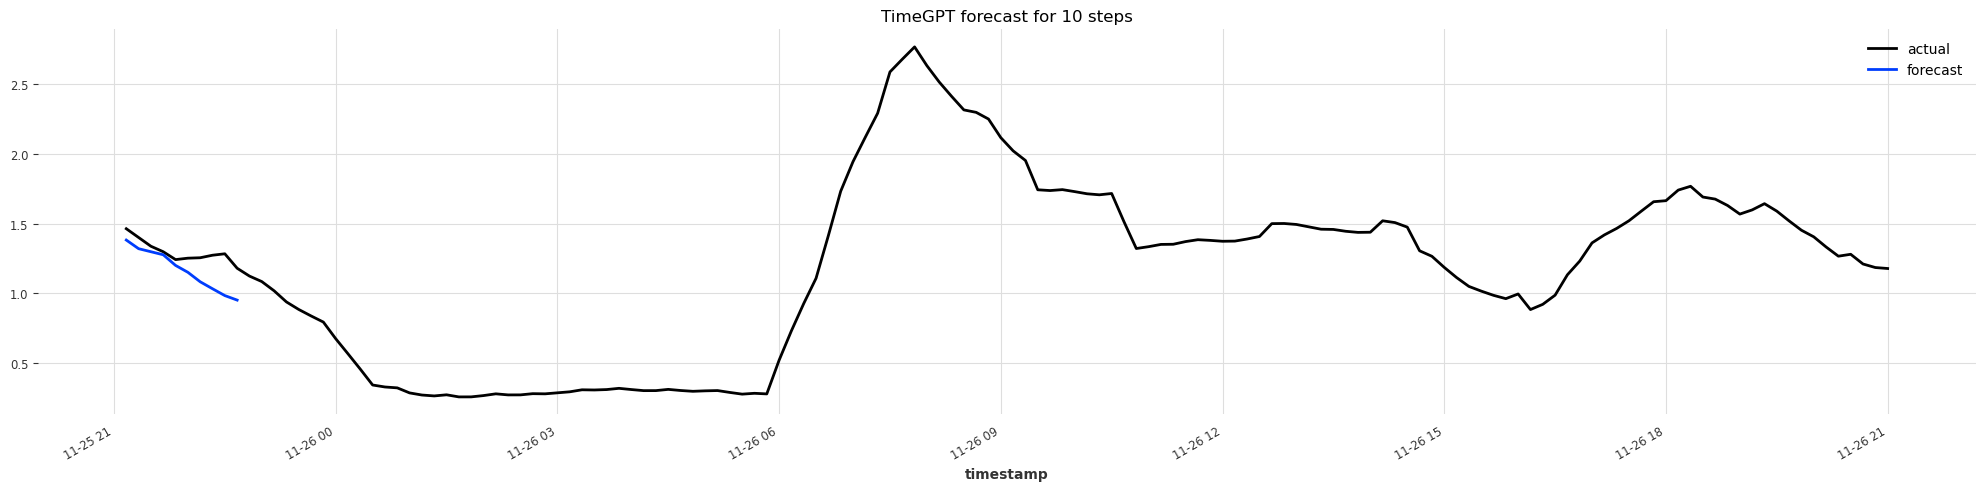

TimeGPT 10 metrics:
MAPE = 10.26%
RMSE = 0.16
MSE = 0.03
MAE = 0.13




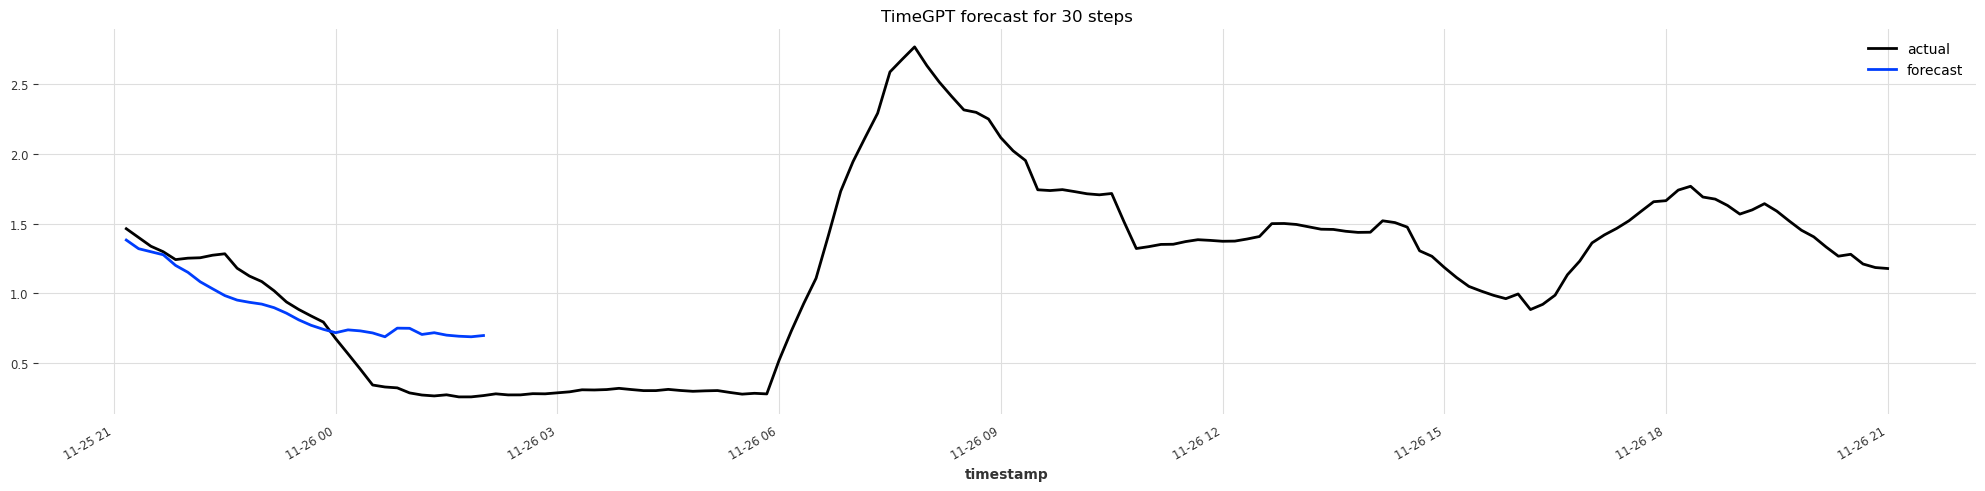

TimeGPT 30 metrics:
MAPE = 59.19%
RMSE = 0.27
MSE = 0.08
MAE = 0.23




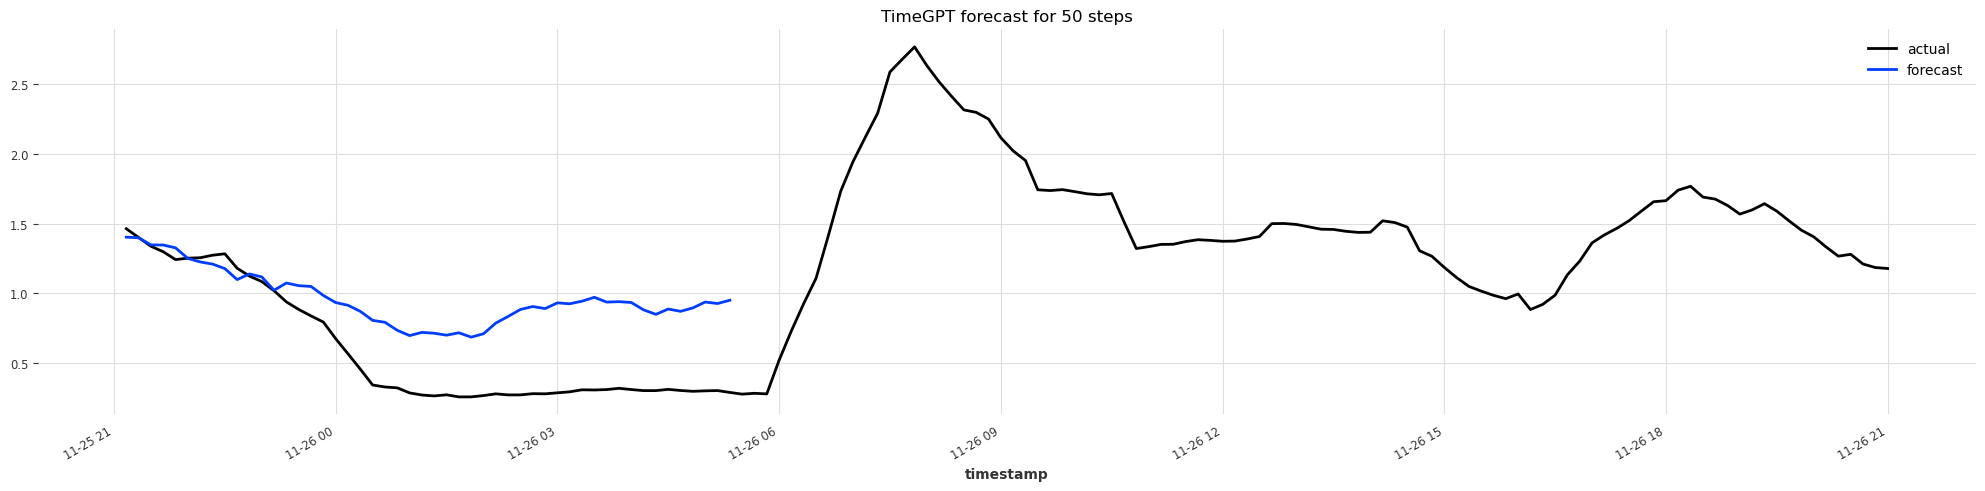

TimeGPT 50 metrics:
MAPE = 119.61%
RMSE = 0.45
MSE = 0.20
MAE = 0.38




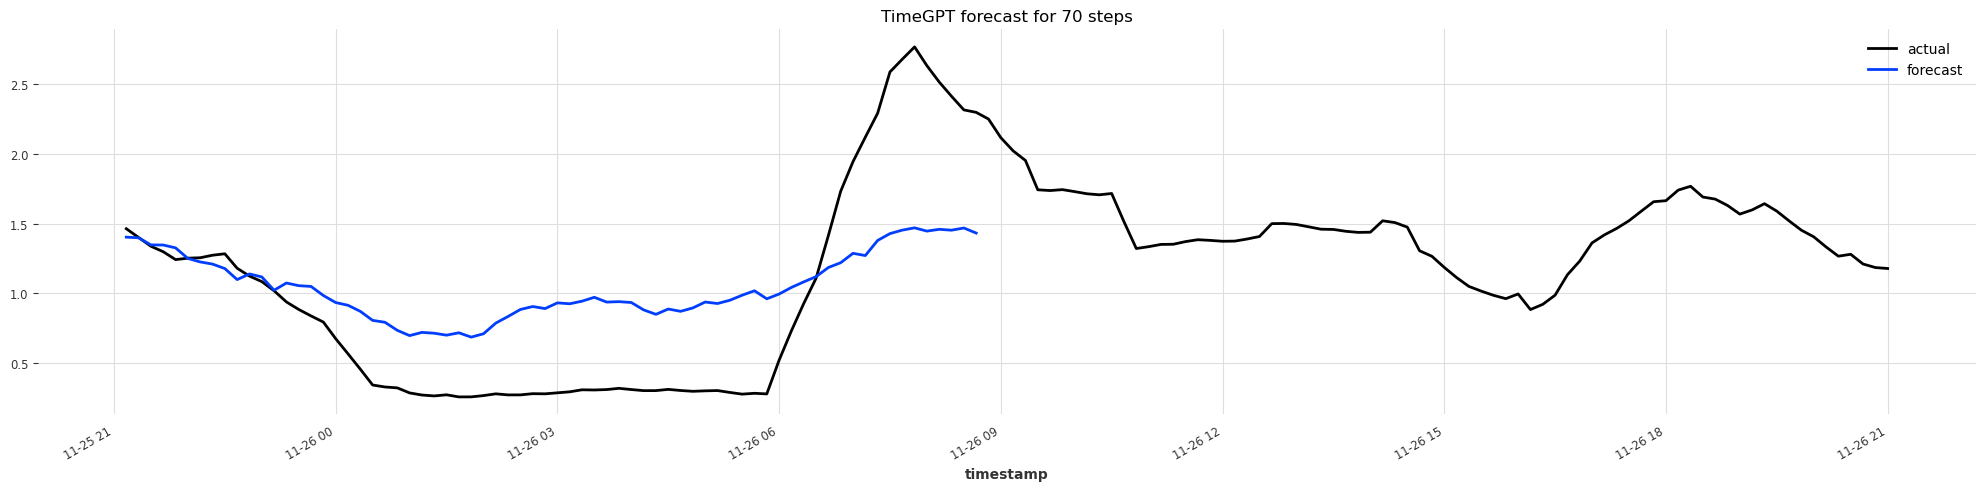

TimeGPT 70 metrics:
MAPE = 105.58%
RMSE = 0.58
MSE = 0.34
MAE = 0.48




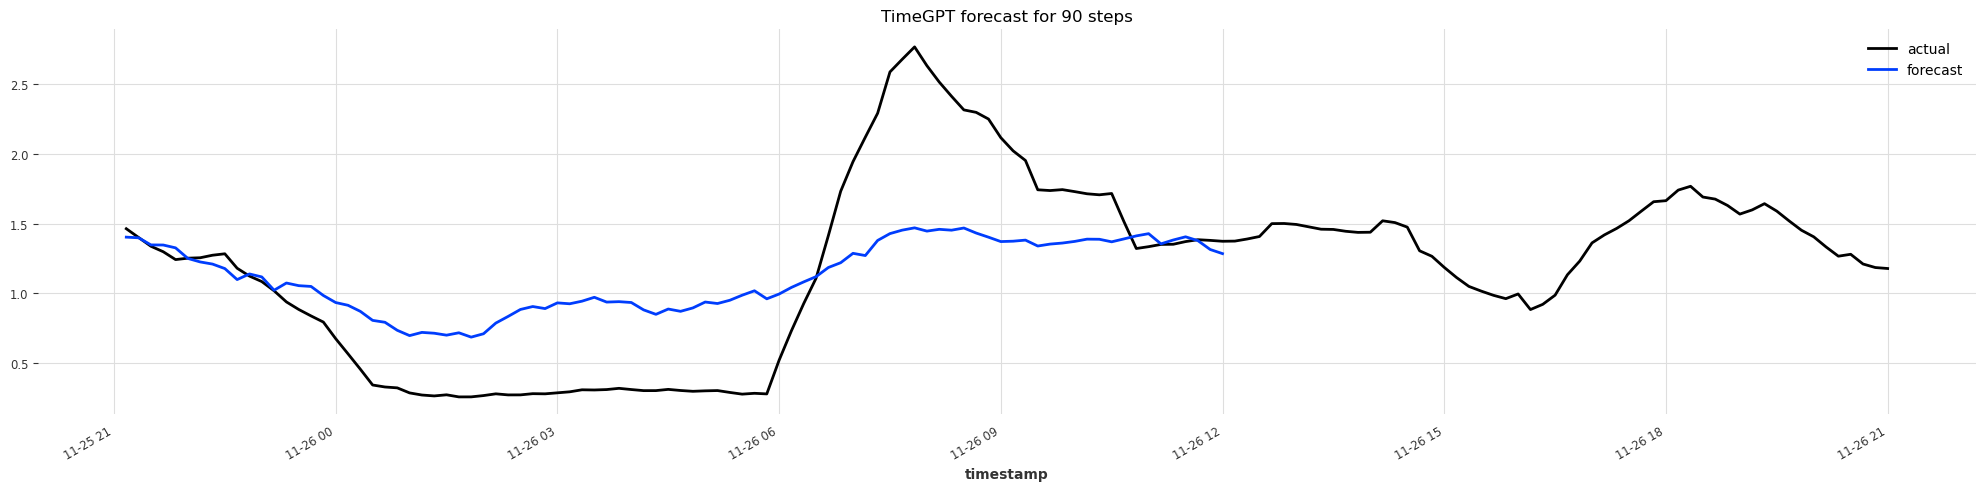

TimeGPT 90 metrics:
MAPE = 85.66%
RMSE = 0.54
MSE = 0.29
MAE = 0.44




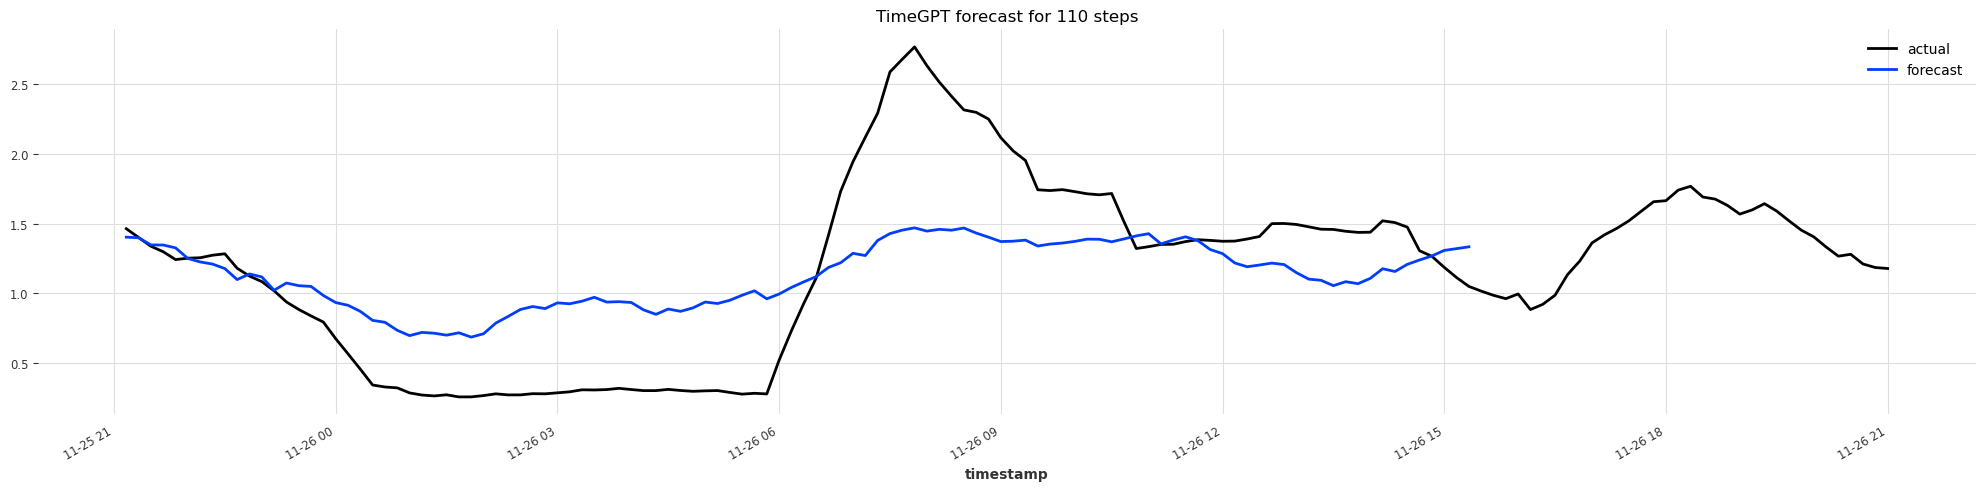

TimeGPT 110 metrics:
MAPE = 73.53%
RMSE = 0.51
MSE = 0.26
MAE = 0.41




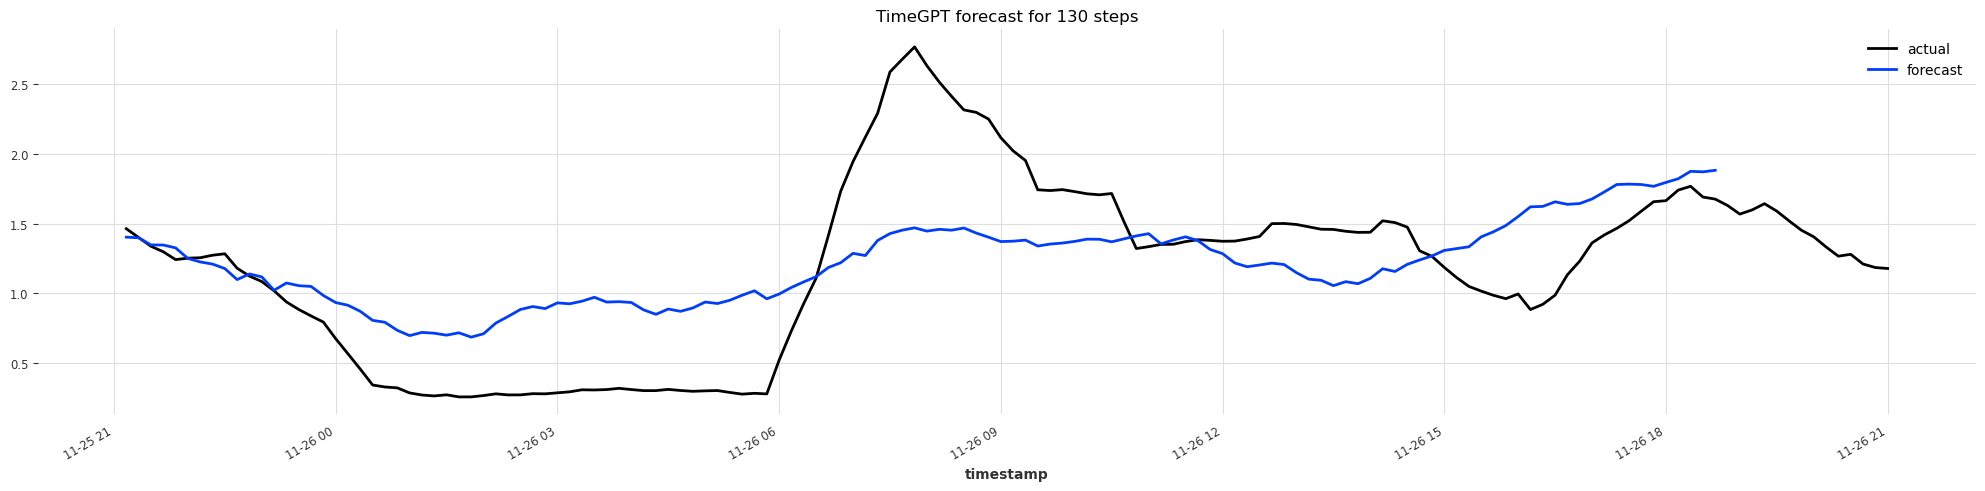

TimeGPT 130 metrics:
MAPE = 67.17%
RMSE = 0.49
MSE = 0.24
MAE = 0.40




In [24]:
# read forecasts timegpt_forecast_*.csv and plot them agains series_after_train
for i in range(10, len(series_after_train), 20):
  # check if the forecast file exists
  try:
    time_gpt_forecast_df = pd.read_csv('data/timegpt_forecast_' + str(i) + '.csv')
  except FileNotFoundError:
    print('forecast file not found for', i)
    continue

  time_gpt_forecast = TimeSeries.from_dataframe(time_gpt_forecast_df, time_col='timestamp', value_cols='TimeGPT')
  plot_forecast(series_after_train, time_gpt_forecast, "TimeGPT forecast for " + str(i) + " steps")

  print_metrics('TimeGPT ' + str(i), series_after_train, time_gpt_forecast)

  print('')

## TimeGPT results
The shorter the prediction horizon, the better the performance of TimeGPT. The best performance is achieved with a prediction horizon of 10 step ahead. taught on the last 60 days dataset. Using whole dataset is pointless, because the results are equally poor / good (with limited prediction steps) but the price is much higher.
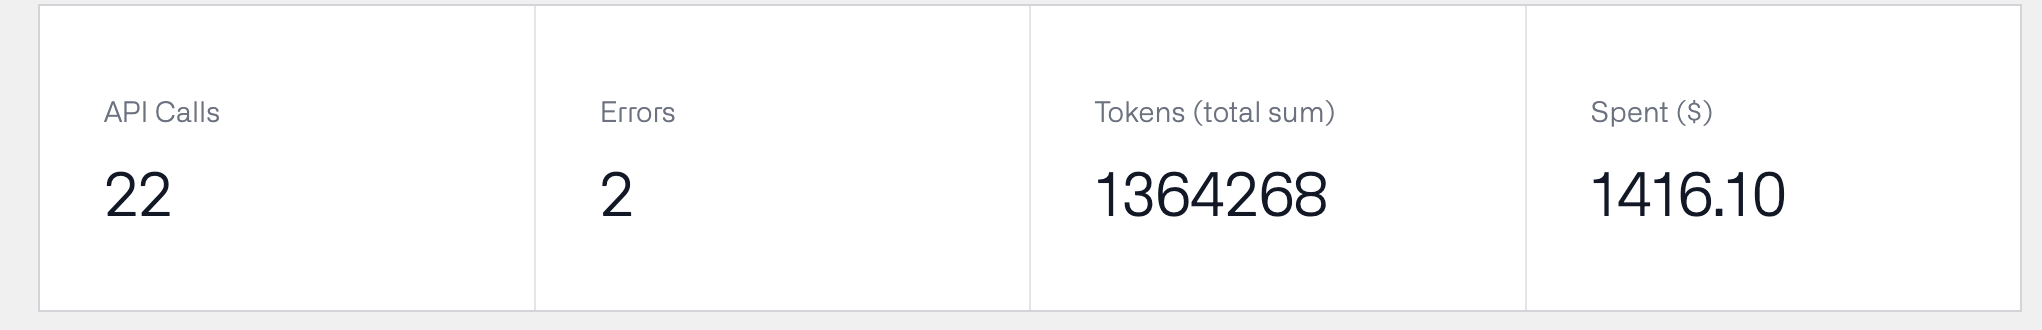

# Prophet

In [25]:
from darts.models import Prophet


In [26]:
prophet = Prophet()

train_last_1000 = train.slice_n_points_before(train.end_time(), 1000)

# check if data/bactest_prophet.csv exists
try:
  backtest_prophet_df = pd.read_csv('data/backtest_prophet.csv')
except FileNotFoundError:
  backtest_prophet_df = None


if backtest_prophet_df is not None:
  print('backtest_prophet loaded')
  backtest = TimeSeries.from_dataframe(backtest_prophet_df, 'ds', 'y')
else:
  backtest = prophet.historical_forecasts(train_last_1000,
                            start=.5,
                            forecast_horizon=10)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/tmpo5i1eavd/6jld6v7j.json


DEBUG:cmdstanpy:input tempfile: /var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/tmpo5i1eavd/6g75kevo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/anaconda3/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96290', 'data', 'file=/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/tmpo5i1eavd/6jld6v7j.json', 'init=/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/tmpo5i1eavd/6g75kevo.json', 'output', 'file=/var/folders/fq/7hdv8yqd3ld281d0kdv2ylc80000gn/T/tmpo5i1eavd/prophet_modelz3zr4r12/prophet_model-20240404193001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:30:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:30:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling 

In [27]:
backtest.to_csv('data/prophet_backtest.csv', index=False)

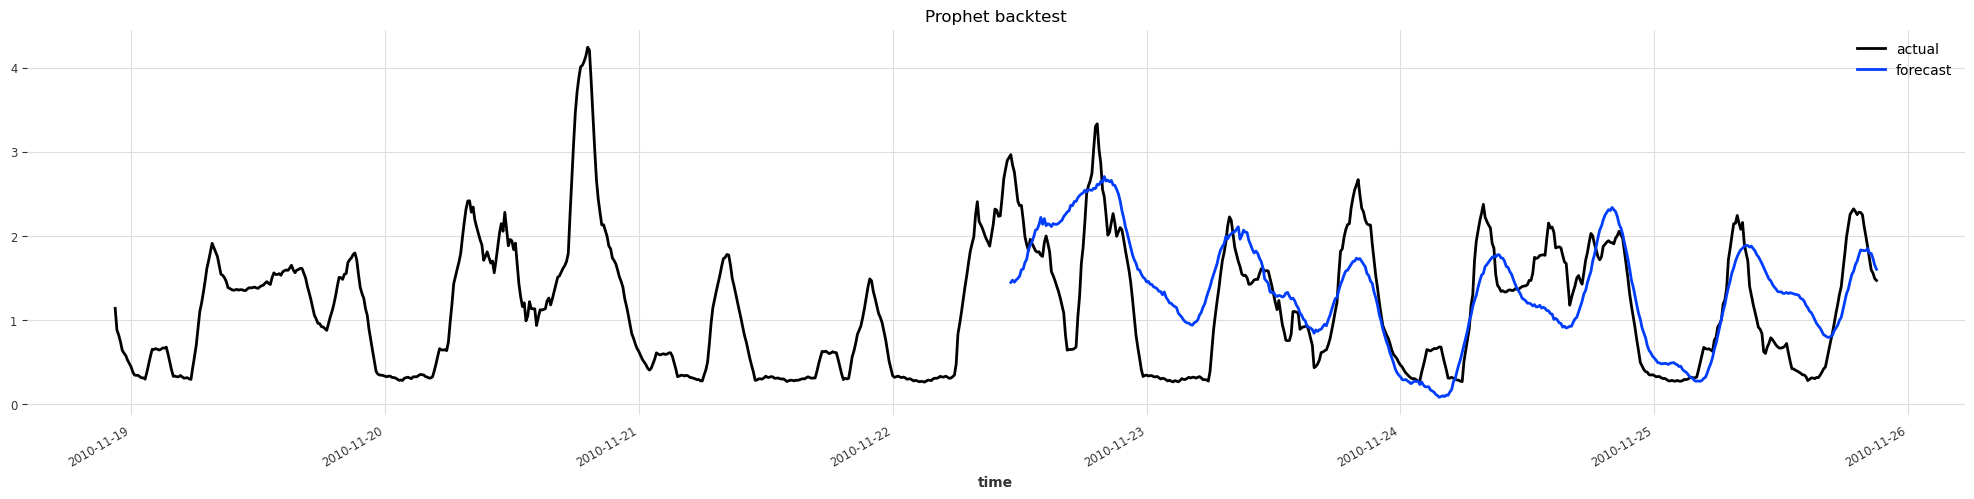

Prophet backtest metrics:
MAPE = 65.68%
RMSE = 0.56
MSE = 0.32
MAE = 0.45



In [28]:
plot_forecast(train_last_1000, backtest, "Prophet backtest")
print_metrics('Prophet backtest', train_last_1000, backtest)


Not bad, certainly better than TimeGPT

----

## Temporal Fusion Transformer

In [29]:
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression

In [30]:
train_covariate = get_series_from_dataframe(df, 'Voltage')

In [31]:
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

input_chunk_length = 24
output_chunk_length = 12

tft = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(quantiles),
    random_state=42,
    pl_trainer_kwargs={'accelerator': 'cpu'},
)

In [32]:
# cast to float32
train = train.astype(np.float32)
train_covariate = train_covariate.astype(np.float32)

In [33]:

tft.fit(train, verbose=True, future_covariates=train_covariate)

INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 8462 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 32-bits; casting model to float32.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelecti

Training: |          | 0/? [00:00<?, ?it/s]

: 

---

# Arima

In [ ]:
print(train)

In [ ]:
# arima model
from darts.models import AutoARIMA

model = AutoARIMA(verbose=True)
model.fit(train)

prediction = model.predict(to_predict, verbose=True)

In [ ]:

plt.figure(figsize=(25,5))
series.plot(label='actual')
prediction.plot(label='forecast', lw=3)

In [ ]:
# exponential smoothing

from darts.models import ExponentialSmoothing

model_es = ExponentialSmoothing(seasonal_periods=7)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.9, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")